In [19]:
import pandas as pd
import numpy as np
import mlfinpy as mlpy
from datetime import datetime, timedelta
import statsmodels.api as sm
# Plotting
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns

ImportError: cannot import name 'intp' from 'numpy._core' (/Users/baobach/anaconda3/envs/mlfinpy/lib/python3.11/site-packages/numpy/_core/__init__.py)

In [2]:
# Load sample ticks
data = mlpy.dataset.load_tick_sample()
# Ensure date_time index in the correct format
data.index = pd.to_datetime(data.index, unit='ns')
data.head()

price  volume
date_time                          
2010-01-03 17:00:00  1113.2     1.0
2010-01-03 17:00:00  1113.2     1.0
2010-01-03 17:00:00  1113.2     1.0
2010-01-03 17:00:00  1113.2     1.0
2010-01-03 17:00:00  1113.2     1.0

## 1. Overlapping Outcomes & Concurrent Labels

First we need to compute `vertical_barriers` series on dollar bars. We again use average daily volatility as return threshold.

In [3]:
# Create dollar bars with $50,000 threshold
dollar_bars = mlpy.data_structure.get_dollar_bars(data, 50_000)
dollar_bars.set_index('date_time', inplace=True)
# Keep first entry if duplicate index
dollar_bars = dollar_bars[~dollar_bars.index.duplicated(keep='first')]
# Average daily volatility to trigger T Events
daily_vol = mlpy.util.get_daily_vol(dollar_bars['close'])
mean_std = daily_vol.mean()
# Find timestamp of significant events using CUSUM filter
t_events = mlpy.filters.cusum_filter(dollar_bars['close'], mean_std)
chosen_bars = dollar_bars.loc[t_events, :]
fig = go.Figure(
    go.Scatter(x=dollar_bars.index, y=dollar_bars['close'],
               line=dict(color="blue", width=1), name='Close Price')
).update_layout(xaxis_title="Time", yaxis_title="Price", title="Close Price and Selected Timestamps")
fig.add_trace(go.Scatter(
    x=chosen_bars.index, y=chosen_bars['close'], mode='markers', marker=dict(size=1), name='Selected Timestamps'
    )
)
fig.show()

Reading data in batches:
Batch number: 0
Returning bars 



In [4]:
vertical_barriers = mlpy.labeling.add_vertical_barrier(t_events, dollar_bars['close'], num_days=1)
events = mlpy.labeling.get_events(
    close = dollar_bars['close'], 
    t_events = t_events, 
    pt_sl = [1,1], 
    target = daily_vol,
    min_ret = 0.007,
    num_threads = 1,
    vertical_barrier_times = vertical_barriers
    )
events


t1      trgt  pt  sl
2010-01-12 05:13:29.000 2010-01-13 05:18:57.000  0.009418   1   1
2010-01-22 05:50:06.000 2010-01-24 17:26:29.000  0.008345   1   1
2010-01-28 23:59:12.000 2010-01-29 07:33:22.000  0.013439   1   1
2010-01-29 01:55:38.000 2010-01-31 17:00:05.000  0.015060   1   1
2010-01-29 07:30:05.000 2010-01-31 17:00:05.000  0.011984   1   1
...                                         ...       ...  ..  ..
2019-12-05 06:58:55.511 2019-12-06 07:51:31.562  0.008570   1   1
2019-12-13 03:22:27.447 2019-12-17 07:25:09.155  0.008487   1   1
2019-12-17 07:25:09.155 2019-12-18 23:48:26.848  0.008532   1   1
2019-12-23 02:56:32.116 2019-12-27 03:06:30.865  0.008388   1   1
2019-12-31 02:21:45.011                     NaT  0.008359   1   1

[1474 rows x 4 columns]

In [5]:
num_conc = mlpy.sampling.num_concurrent_events(dollar_bars.index, events['t1'], events.index)
num_conc

date_time
2010-01-12 05:13:29.000    1
2010-01-12 05:14:15.000    1
2010-01-12 05:21:23.000    1
2010-01-12 05:30:20.000    1
2010-01-12 05:34:44.000    1
                          ..
2019-12-17 15:52:04.130    1
2019-12-18 23:48:26.848    1
2019-12-23 02:56:32.116    1
2019-12-27 03:06:30.865    1
2019-12-31 02:21:45.011    1
Length: 80419, dtype: int64

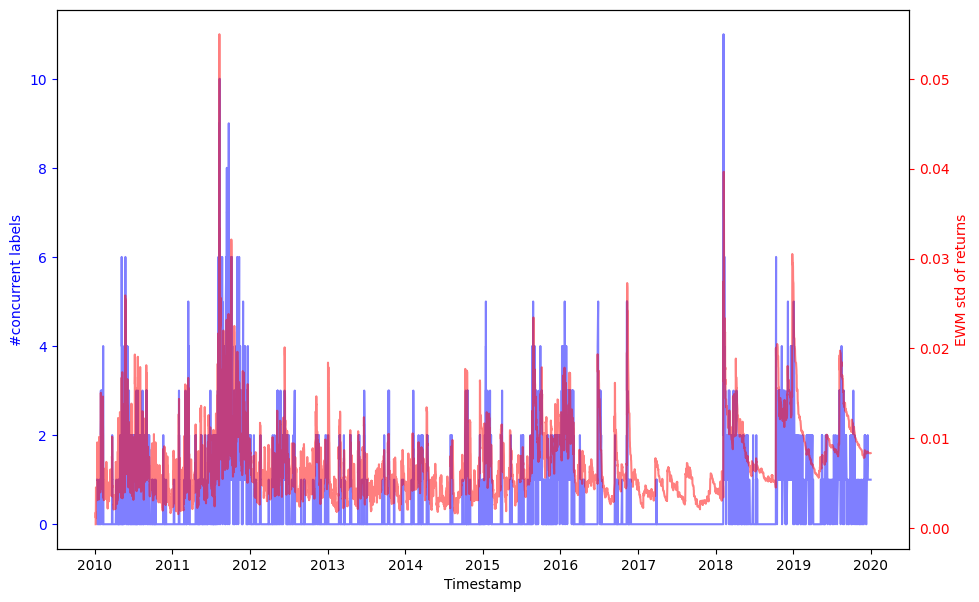

In [6]:
fig, ax = plt.subplots(figsize=(11, 7))
ax2 = ax.twinx()
ax.plot(num_conc, color='blue', alpha=0.5) 
ax2.plot(daily_vol, color='red', alpha=0.5)
ax.set_xlabel('Timestamp')
ax.set_ylabel('#concurrent labels', color='blue')
ax.tick_params(axis='y', color='blue', labelcolor='blue')
ax2.set_ylabel('EWM std of returns', color='red')
ax2.tick_params(axis='y', color='red', labelcolor='red')
plt.show()

In [11]:
list(daily_vol.index)

[Timestamp('2010-01-04 17:12:20'),
 Timestamp('2010-01-04 18:11:38'),
 Timestamp('2010-01-04 18:45:44'),
 Timestamp('2010-01-04 20:04:03'),
 Timestamp('2010-01-04 21:20:44'),
 Timestamp('2010-01-04 22:43:50'),
 Timestamp('2010-01-05 00:54:24'),
 Timestamp('2010-01-05 01:52:48'),
 Timestamp('2010-01-05 02:15:08'),
 Timestamp('2010-01-05 02:42:47'),
 Timestamp('2010-01-05 02:43:12'),
 Timestamp('2010-01-05 02:51:42'),
 Timestamp('2010-01-05 03:08:46'),
 Timestamp('2010-01-05 03:09:58'),
 Timestamp('2010-01-05 03:10:49'),
 Timestamp('2010-01-05 03:14:29'),
 Timestamp('2010-01-05 03:30:51'),
 Timestamp('2010-01-05 03:44:08'),
 Timestamp('2010-01-05 04:06:00'),
 Timestamp('2010-01-05 04:18:52'),
 Timestamp('2010-01-05 04:35:10'),
 Timestamp('2010-01-05 04:57:35'),
 Timestamp('2010-01-05 05:01:48'),
 Timestamp('2010-01-05 05:02:56'),
 Timestamp('2010-01-05 05:15:46'),
 Timestamp('2010-01-05 05:19:16'),
 Timestamp('2010-01-05 05:20:32'),
 Timestamp('2010-01-05 05:47:22'),
 Timestamp('2010-01-

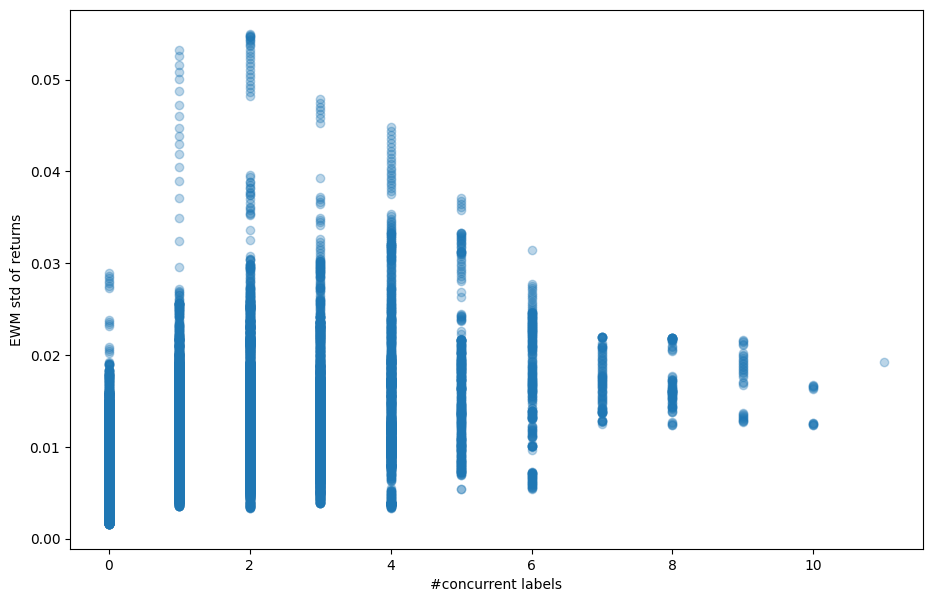

In [15]:
fig, ax = plt.subplots(figsize=(11, 7))
ind = set(num_conc.index).intersection(set(daily_vol.index))
# Convert the set to a list for indexing
ind = list(ind)
ax.scatter(num_conc[ind], daily_vol[ind], alpha=0.3)
ax.set_xlabel('#concurrent labels')
ax.set_ylabel('EWM std of returns')
plt.show()


## 2. Average Uniqueness of Each Label

In [ ]:
events = events.dropna()
avg_uniq = mlpy.sample_weights.get_weights_by_return(events, dollar_bars['close'])

rcParams['figure.figsize'] = 10, 5
with sns.axes_style('whitegrid'):
    sm.graphics.tsa.plot_acf(avg_uniq[:-1], lags=[0, 1, 2, 3, 5, 10], lw=3)

## 3. Random Forest, OOB&CV accuracy

Let's train random forest on some artificial financial dataset. We will use current and previous close prices along with current volatility to predict whether the next close price will be higher or lower.

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

ind = daily_vol.index
data = pd.DataFrame({'close current': dollar_bars['close'][ind].values,
                     'close previous': dollar_bars['close'].shift(1)[ind].values,
                     'vol current': daily_vol.values,
                     'close next': dollar_bars['close'].shift(-1)[ind].values}).dropna()
X = data.drop('close current', axis=1)
y = (data['close next'] > data['close current']).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf = RandomForestClassifier(n_estimators=25, oob_score=True, n_jobs=-1)
rf.fit(X_train, y_train)

/Users/baobach/anaconda3/envs/mlfinpy/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.



RandomForestClassifier(n_estimators=25, n_jobs=-1, oob_score=True)

In [23]:
print(f'RF OOB accuracy: {rf.oob_score_}')

RF OOB accuracy: 0.628276225292769


In [24]:
accuracies = cross_val_score(rf, X, y, cv=5)
print(f'RF mean cross validation accuracy: {accuracies.mean()}')

RF mean cross validation accuracy: 0.5445814486647251


/Users/baobach/anaconda3/envs/mlfinpy/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.



We can notice that the CV score is significantly lower than the out-of-bag score. This is due to the incorrect assumption of IID samples that decision trees are trained on. In our case this implies that the trees in the random forest are not different enough and the CV accuracy estimation is a less biased estimation.